In [1]:
import logging
import torch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from pathlib import Path
from utils import tools, metrics
from modules.cae_base_module import CAEBaseModule
from models import supported_models
from datasets import supported_datamodules

plt.style.use('seaborn')

In [2]:
# Import configurations and paths to logged models
root = Path.cwd() / '..'
log_path = root / 'logs' / 'CuriosityDataModule'
paths_to_archived_models = Path(log_path).glob('**/*CAE*/archive*')

module_catalog = {}

for pth in paths_to_archived_models:
    print(pth)
    config = tools.load_config(pth / 'configuration.yaml', silent=True)
    model_type = pth.parent.name
    model_name = pth.name
    model_path = next(iter((pth / 'checkpoints').glob('val_loss*')))
    
    datamodule = supported_datamodules[config['experiment-parameters']['datamodule']](
        **config['data-parameters'])
    datamodule.setup('test')

    model = supported_models[config['experiment-parameters']['model']](
        in_shape=datamodule.data_shape)

    module = CAEBaseModule(model, **config['module-parameters'])
    
    # Load the state_dict into the module architecture
    checkpoint = torch.load(model_path)
    module.load_state_dict(checkpoint['state_dict'])
    
    if model_type not in module_catalog:
        module_catalog[model_type] = {}
    module_catalog[model_type][model_name] = module

/home/brahste/Projects/novelty-detection/experiments/../logs/CuriosityDataModule/BaselineCAE/archive_v3_2021-04-22
/home/brahste/Projects/novelty-detection/experiments/../logs/CuriosityDataModule/BaselineCAE/archive_v2_2021-04-21
/home/brahste/Projects/novelty-detection/experiments/../logs/CuriosityDataModule/BaselineCAE/archive_v4_2021-04-22
/home/brahste/Projects/novelty-detection/experiments/../logs/CuriosityDataModule/BaselineCAE/archive_v1_2021-04-12
/home/brahste/Projects/novelty-detection/experiments/../logs/CuriosityDataModule/CompressionCAEHighCapacity/archive_v1_2021-04-22
/home/brahste/Projects/novelty-detection/experiments/../logs/CuriosityDataModule/CompressionCAEMidCapacity/archive_v1_2021-04-21


In [3]:
# Collect scores and labels for all models into a catalog
scores = pd.DataFrame()
labels = pd.DataFrame()
for model_type, model_variants in module_catalog.items():
    
    for model_name, module in model_variants.items():
        
        test_novelty_scores = []
        test_novelty_labels = []
        short_name = model_type + '-' + model_name.split('_')[1]
        print(f'{short_name}\n-----')
        module.model.eval()  # Freeze dropout and batch normalization parameters
        
        with torch.no_grad():
            for batch_nb, batch in enumerate(datamodule.test_dataloader()):
                
                result = module.test_step(batch, batch_nb)

                test_novelty_scores.extend(result['scores'].cpu().numpy())
                test_novelty_labels.extend(result['labels'].cpu().numpy())
                print(f'[BATCH {batch_nb}] Mean score: {result["scores"].mean()}')
            scores.loc[:, short_name] = test_novelty_scores
            labels.loc[:, short_name] = test_novelty_labels

BaselineCAE-v3
-----
[BATCH 0] Mean score: 0.3059125542640686
[BATCH 1] Mean score: 0.30634617805480957
[BATCH 2] Mean score: 0.29024773836135864
[BATCH 3] Mean score: 0.3264658451080322
[BATCH 4] Mean score: 0.32600831985473633
[BATCH 5] Mean score: 0.33382850885391235
BaselineCAE-v2
-----
[BATCH 0] Mean score: 0.3116724193096161
[BATCH 1] Mean score: 0.3120186924934387
[BATCH 2] Mean score: 0.2951187491416931
[BATCH 3] Mean score: 0.3340558111667633
[BATCH 4] Mean score: 0.3351689279079437
[BATCH 5] Mean score: 0.34266310930252075
BaselineCAE-v4
-----
[BATCH 0] Mean score: 0.3348437249660492
[BATCH 1] Mean score: 0.34023892879486084
[BATCH 2] Mean score: 0.32003912329673767
[BATCH 3] Mean score: 0.40768831968307495
[BATCH 4] Mean score: 0.45102518796920776
[BATCH 5] Mean score: 0.46083885431289673
BaselineCAE-v1
-----
[BATCH 0] Mean score: 0.3289339542388916
[BATCH 1] Mean score: 0.3343113660812378
[BATCH 2] Mean score: 0.314333975315094
[BATCH 3] Mean score: 0.4012742042541504
[BATC

BaselineCAE-v3 ROC AUC: 0.5847953216374269
BaselineCAE-v2 ROC AUC: 0.590382450649315
BaselineCAE-v4 ROC AUC: 0.6882876204595997
BaselineCAE-v1 ROC AUC: 0.6889053619965406
CompressionCAEHighCapacity-v1 ROC AUC: 0.6030255607720397
CompressionCAEMidCapacity-v1 ROC AUC: 0.6839222469318836


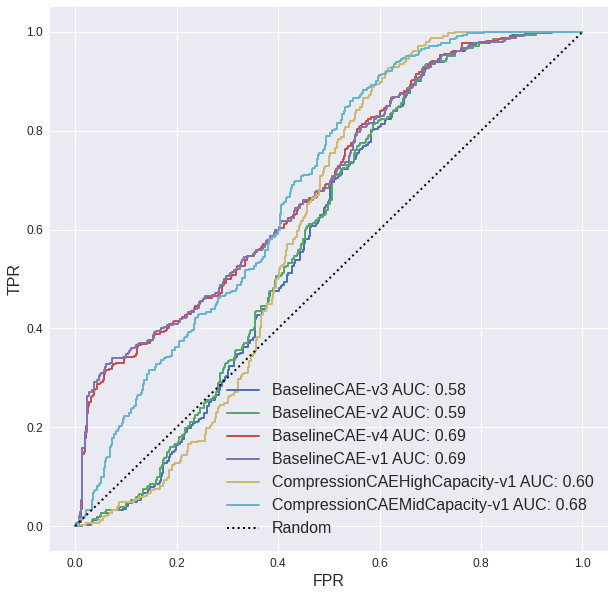

Random ROC AUC: 0.5


In [6]:
plt.figure(figsize=(10,10))
for col in scores:
    fpr, tpr, thresholds, auc = metrics.roc(scores[col], labels[col])

    plt.plot(fpr, tpr, lw=2., label=f'{col} AUC: {auc:.2f}')

    print(f'{col} ROC AUC: {auc}')
    
plt.plot([0., 1.], [0., 1.], 'k:', lw=2, label='Random')
plt.legend(fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.show()
print('Random ROC AUC: 0.5')

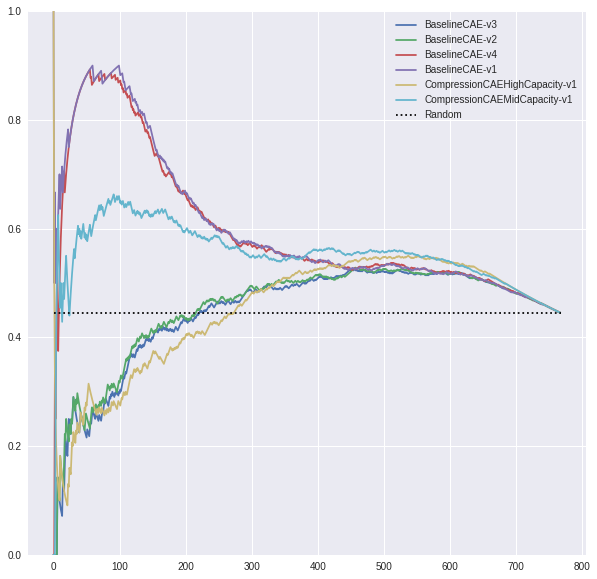

In [7]:
plt.figure(figsize=(10,10))
for col in scores:
    pak = metrics.precision_at_k(scores[col], labels[col])

    uniques, counts = np.unique(labels[col], return_counts=True)
    random = counts.min() / counts.sum()

    plt.plot(pak, label=f'{col}')
    
plt.plot([0, len(pak)], [random, random], 'k:', label='Random')
plt.ylim([0., 1.])
plt.legend()
plt.show()